In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [3]:
image_filenames_train = []


# in Kaggle
mask_files = glob('/content/drive/MyDrive/Colab Notebooks/augmented_dataset/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_CS_6188_20010812_2_aug1.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_DU_5872_19950223_14_aug0.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_DU_7309_19960831_39_aug1.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_FG_A4MT_20020212_26_aug0.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_CS_6188_20010812_4_aug0.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_CS_6668_20011025_14_aug0.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_FG_A4MT_20020212_26_aug1.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TCGA_FG_A4MT_20020212_27_aug0.tif', '/content/drive/MyDrive/Colab Notebooks/augmented_dataset/augmented_non_tumour/TC

7779

In [ ]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

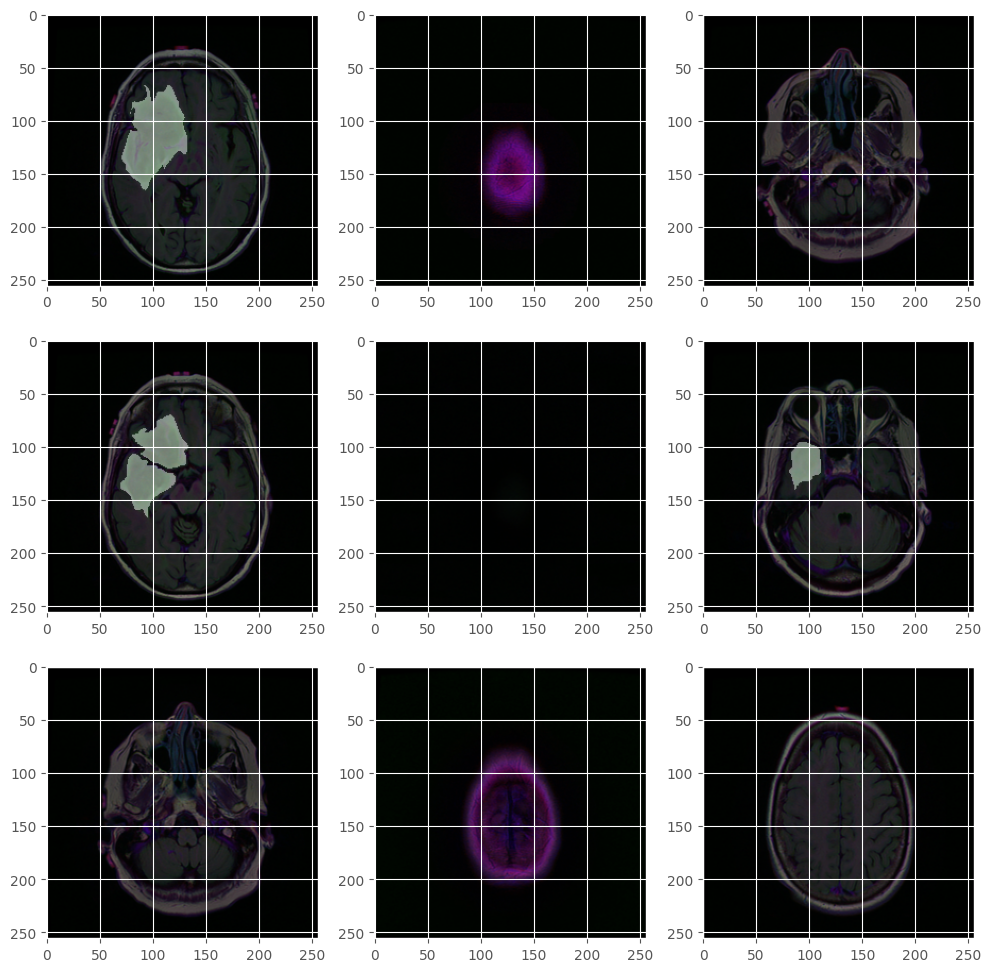

In [ ]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [ ]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    union = tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

In [ ]:
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

In [ ]:
def iou(y_true, y_pred, smooth=100):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    sum = tf.keras.backend.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [4]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(5600, 2)
(778, 2)
(1401, 2)


In [ ]:
print(df.head())

                               image_filenames_train  \
0  /content/drive/MyDrive/Colab Notebooks/archive...   
1  /content/drive/MyDrive/Colab Notebooks/archive...   
2  /content/drive/MyDrive/Colab Notebooks/archive...   
3  /content/drive/MyDrive/Colab Notebooks/archive...   
4  /content/drive/MyDrive/Colab Notebooks/archive...   

                                                mask  
0  /content/drive/MyDrive/Colab Notebooks/archive...  
1  /content/drive/MyDrive/Colab Notebooks/archive...  
2  /content/drive/MyDrive/Colab Notebooks/archive...  
3  /content/drive/MyDrive/Colab Notebooks/archive...  
4  /content/drive/MyDrive/Colab Notebooks/archive...  


In [ ]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
      if img.shape[0] == batch_size and mask.shape[0] == batch_size:  # Check batch size
            img, mask = normalize_and_diagnose(img, mask)
            yield (img, mask)
      else:
            print(" Dropping last incomplete batch")  # Optional: Print message for clarity

In [ ]:
''' After mask Normalization if the value is <= 0.5 then that Mask
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
epochs = 50
batch_size = 32
learning_rate = 1e-4#0.0004
smooth = 100

In [ ]:
import tensorflow as tf #deep learning framework
from tensorflow.keras import Input #starting layer of the model
from tensorflow.keras.models import Model, load_model, save_model #to create, load and save models
from tensorflow.keras.layers import (
    Input,
    Activation, #defines activation functions
    BatchNormalization, #Normalizes activations to speed up training and stabilize learning
    Dropout, #Prevents overfitting by randomly disabling some neurons
    Conv2D, #Performs 2D convolution for feature extraction
    Conv2DTranspose, #Used for upsampling in the decoder
    MaxPooling2D, #Downsamples the feature maps
    concatenate, #Combines feature maps from different layers
)

from tensorflow.keras import backend as K #imports keras backend functions


def unet(input_size=(im_width, im_height, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D((2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D((2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(1024, (3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, (3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, (3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, (3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, (3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10]) #creates and returns model

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, batch_size,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, batch_size,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))


from tensorflow.keras.optimizers import Adam


opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=(len(df_train) // batch_size),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=(len(df_val) // batch_size))

Found 2830 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - binary_accuracy: 0.6929 - dice_coefficients: 0.0371 - iou: 0.0190 - loss: -0.0371 Found 708 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="image_filenames_train". These filename(s) will be ignored.
  warnings.warn(


Found 710 validated image filenames.
 Dropping last incomplete batch

Epoch 1: val_loss improved from inf to -0.02008, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 2433s 27s/step - binary_accuracy: 0.6934 - dice_coefficients: 0.0372 - iou: 0.0191 - loss: -0.0372 - val_binary_accuracy: 0.6158 - val_dice_coefficients: 0.0201 - val_iou: 0.0102 - val_loss: -0.0201
Epoch 2/50
 4/88 ━━━━━━━━━━━━━━━━━━━━ 1:14 882ms/step - binary_accuracy: 0.8027 - dice_coefficients: 0.0617 - iou: 0.0320 - loss: -0.0617 Dropping last incomplete batch
87/88 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - binary_accuracy: 0.8001 - dice_coefficients: 0.0553 - iou: 0.0286 - loss: -0.0553 Dropping last incomplete batch
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.8001 - dice_coefficients: 0.0553 - iou: 0.0286 - loss: -0.0553 Dropping last incomplete batch

Epoch 2: val_loss did not improve from -0.02008
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - binary_accuracy: 0.8001 - dice_coefficients: 0.0553 - iou: 0.02

In [ ]:
# Save the model to an HDF5 file
model.save("unet_brain.h5")